In [2]:
# Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [3]:
# Reading the final dataset

df=pd.read_csv("finaldata.csv")
df.head()

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference
0,1.22.35.226,6,6.0,6,6,1.338050e+04,1.943990e+04,7.000000
1,100.2.4.116,6,3.0,6,6,1.811173e+07,2.803655e+07,1201.666667
2,100.43.83.137,84,21.0,84,56,1.505974e+04,1.469133e+04,2485.226190
3,101.119.18.35,33,33.0,33,32,7.144242e+04,1.136064e+05,1.696970
4,101.199.108.50,3,3.0,3,3,1.460800e+04,2.029127e+04,5.000000


# K-Means Clustering Algorithm

In [4]:
# Features chosen for the model 

chosen_data = df[['Total Requests', 'Daily Mean', 'GET requests',
       'Successful requests', 'Mean Return Size', 'Return Size Std',
       'Mean Time Difference']]

In [5]:
# Scalling all features to lie between 0 and 1 using MinMaxScaler

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(chosen_data)
chosen_data = pd.DataFrame(np_scaled, columns=chosen_data.columns)

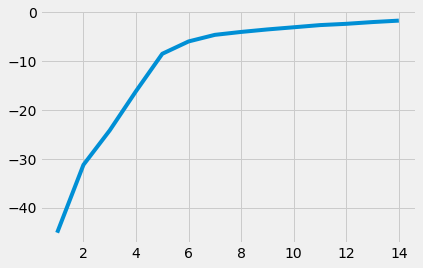

In [6]:
# Creating elbow plot to identify optimal number of clusters

n_cluster = range(1, 15)
kmeans = [KMeans(n_clusters=i, random_state=42).fit(chosen_data) for i in n_cluster]
scores = [kmeans[i].score(chosen_data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [7]:
# Assigning cluster number to each data point

cluster_model = kmeans[4]
df['cluster'] = cluster_model.predict(chosen_data)
df['cluster'].value_counts()

0    1657
1      63
2      15
3      14
4       4
Name: cluster, dtype: int64

In [8]:
# Visualising multidimensional data in 2D plane

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=500, random_state=42)
tsne_results = tsne.fit_transform(chosen_data)
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

In [9]:
# Finding cluster centroids 

tsne_cluster = df.groupby('cluster').agg({'tsne-2d-one':'mean', 'tsne-2d-two':'mean'}).reset_index()

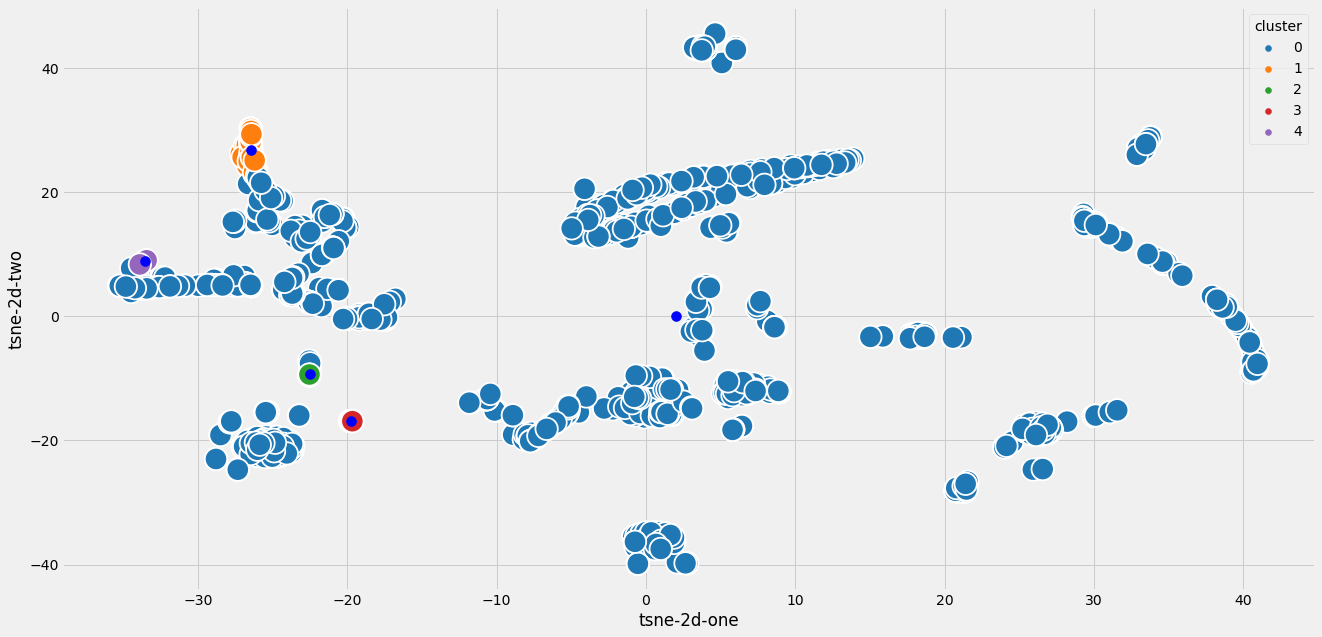

In [10]:
# Plotting 2D Scatterplot visualisation coloured according to cluster

plt.figure(figsize=(20,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=df,
    hue="cluster",
    palette=sns.color_palette("tab10", 5),
    legend="full",
    alpha=1,
    s=500
)

plt.scatter(x="tsne-2d-one", y="tsne-2d-two", data=tsne_cluster, s=100, c='b')

plt.show()

In [11]:
# Function to calculate sum of squared distance between each data point and centroid

def get_sum_square_distance(data, cluster_model):
    centers = cluster_model.cluster_centers_
    points = np.asarray(data[chosen_data.columns])
    total_distance = pd.Series(dtype='float64')
    for i in range(len(points)):
        distance = 0
        for j in range(len(centers)):
            a = np.linalg.norm(points[i] - centers[j])
            distance += a**2
        total_distance.at[i]= distance
    
    return total_distance

df['ssd'] = get_sum_square_distance(chosen_data, cluster_model)

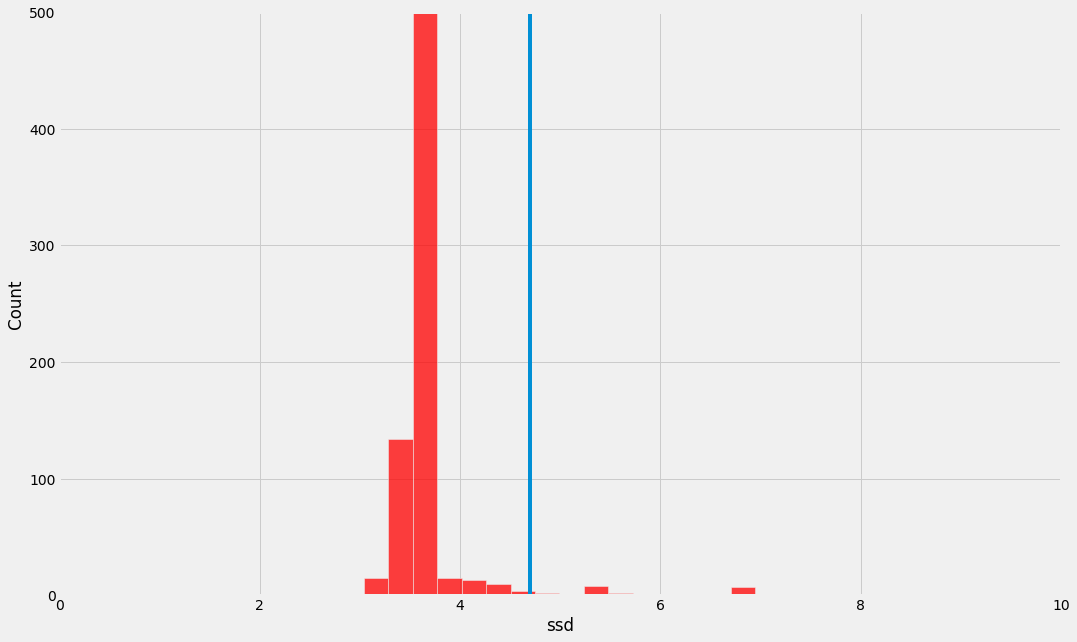

In [12]:
# Ploting histogram on sum of squared distance to find cutoff for anomalous requests

plt.figure(figsize=(16,10))
histo = sns.histplot(data=df,x="ssd",bins=50,color='red')
histo.set(xlim=(0,10),ylim=(0,500))
plt.axvline(4.7, 0, label="Cutoff")

In [13]:
# Labelling KMean Anomalies 

cutoff = 4.7
df['anomaly_kmeans'] = (df['ssd'] >= cutoff).astype(int)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

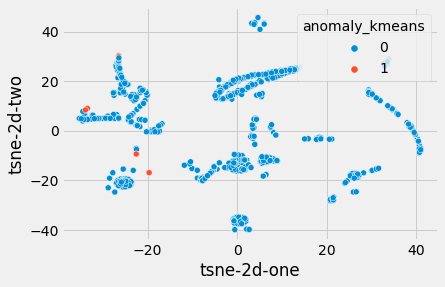

In [14]:
# Scatterplot visualisation of anomalous requests

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_kmeans",
    data=df,
    legend="full",
    alpha=1
)

In [15]:
# Number of API misuse/abuse detected:

len(df[df['anomaly_kmeans']==1])

29

# Isolation Forests

In [16]:
# Estimating fraction of outliers based on KMeans

outlier_fraction = len(df[df['anomaly_kmeans']==1])/len(df)
print(outlier_fraction)

# Generating Isolation Forest model using 1% contamination for API misuse requests
outlier_fraction = 0.01
model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=3, random_state=42, contamination=0.01)

0.01654306902452938


In [17]:
model.fit(chosen_data)

IsolationForest(contamination=0.01, max_features=3, n_estimators=200, n_jobs=-1,
                random_state=42)

In [18]:
df['anomaly_isolated'] = pd.Series(model.predict(chosen_data))

In [19]:
# Labelling anomalous requests detected by Isolation Forest 

df['anomaly_isolated'] = df['anomaly_isolated'].map( {1: 0, -1: 1} )
df['anomaly_isolated'].value_counts()

0    1735
1      18
Name: anomaly_isolated, dtype: int64

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

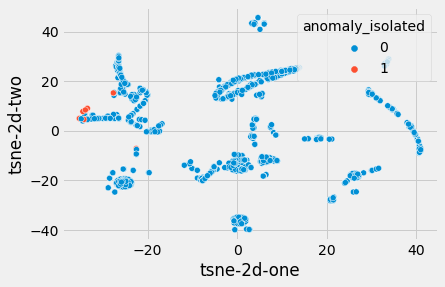

In [20]:
# Scatterplot visualisation 

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_isolated",
    data=df,
    legend="full",
    alpha=1
)

# One Class SVM

In [21]:
# Generating One Class SVM for detection of anomalous requests

model1 =  OneClassSVM(nu=outlier_fraction, degree=2, kernel='rbf')
data_new_clean = chosen_data[chosen_data['Total Requests'] <=chosen_data['Total Requests'].quantile(1-outlier_fraction)]
model1.fit(data_new_clean)

OneClassSVM(degree=2, nu=0.01)

In [22]:
df['anomaly_svm'] = pd.Series(model1.predict(chosen_data))

In [23]:
df['anomaly_svm'] = df['anomaly_svm'].map( {1: 0, -1: 1} )
df['anomaly_svm'].value_counts()

0    1652
1     101
Name: anomaly_svm, dtype: int64

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

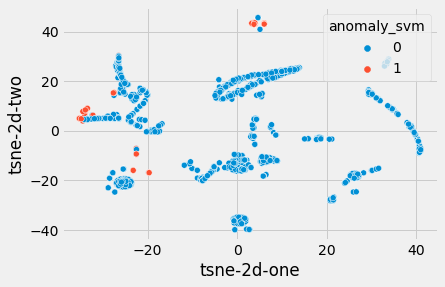

In [24]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_svm",
    data=df,
    legend="full",
    alpha=1
)